# Imports

In [2]:
%%capture
!pip install pysptk

In [15]:
import librosa
import pysptk
import IPython.display as ipd
from scipy.io.wavfile import write

import numpy as np
import statistics
import os
import json
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, accuracy_score, auc, recall_score, precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from keras.layers import Dense, Dropout, Input, Conv2D, MaxPool2D, BatchNormalization, Flatten
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data Processing Functions

In [4]:
def analyse_dataset(dataset_path, metadata_path, sr=16000, min_length=1, min_voiced_sec=0.08):
  """
  Analyses a dataset and returns some data information, includind the files which
  are not valid:
  - Shorter than min_length
  - Empty
  - Without meaningful voiced material
  """
  audio_paths = []
  speaker_labels = []
  audio_lengths = []
  audio_channels = []
  gender_labels = []
  discarded_paths = []

  for root, subdirs, files in os.walk(dataset_path):
    for file in files:
      if file.split('.')[-1] == 'flac' or file.split('.')[-1] == 'wav':
        filepath = os.path.join(root, file)
        label = file.split('-')[0]
        audio, _ = librosa.load(filepath, sr=sr, mono=False)

        # Check if the audio is long enough, valid and has meaningful speech material
        if len(audio) * sr >= min_length and librosa.util.valid_audio(audio, mono=is_mono(audio))\
            and is_voiced(audio, sr, min_voiced_sec):
            audio_paths.append(filepath)
            speaker_labels.append(label)
            audio_lengths.append(len(audio))
            audio_channels.append(is_mono(audio))
        else:
          discarded_paths.append(filepath)
  
  metadata = pd.read_csv(metadata_path, sep='\s+\|\s+', skiprows=11, error_bad_lines=False, engine='python')
  gender_labels = [metadata[metadata["ID"] == int(l)]["SEX"].iloc[0] for i, l in enumerate(speaker_labels)]

  return np.array(audio_paths), np.array(speaker_labels), np.array(gender_labels)\
      ,np.array(audio_lengths), np.array(audio_channels), np.array(discarded_paths)

def print_statistics(audio_paths, speaker_labels, gender_labels, audio_lengths, audio_channels, discarded_paths):
  """
  Given the information provided by analyse_dataset prints a series of global and
  class-related statistics about the dataset files. 
  """
  print('GLOBAL STATISTICS')
  print()
  print(' - Tot. n. of audios: {}'.format(len(audio_paths)))
  print(' - Tot. n. of speakers: {}'.format(len(np.unique(np.array(speaker_labels)))))
  print(' - Tot. n. of discarded audios: {}'.format(len(discarded_paths)))
  print(' - Max length: {}'.format(max(audio_lengths) / sr))
  print(' - Min length: {}'.format(min(audio_lengths) / sr))
  print(' - Avg length: {}'.format(sum(audio_lengths) / len(audio_lengths) / sr))
  print(' - Median length: {}'.format(statistics.median(audio_lengths) / sr))
  print(' - Number of mono audios: {}'.format((audio_channels == True).sum()))
  print(' - Number of stereo audios: {}'.format((audio_channels == False).sum()))  
  print()
  print()
  print()

  print('GENDER STATISTICS')
  print()
  for i, gender in enumerate(np.unique(gender_labels)):
    gen_indices = np.where(gender_labels == gender)[0]
    gen_audio_lengths = [audio_lengths[i] for i in gen_indices]
    gen_audio_channels = [audio_channels[i] for i in gen_indices]
    print('{}) Gender: {}'.format(i + 1, gender))
    print('     - N. audios: {}'.format(len(gen_indices)))
    print('     - Max length: {}'.format(max(gen_audio_lengths) / sr))
    print('     - Min length: {}'.format(min(gen_audio_lengths) / sr))
    print('     - Avg length: {}'.format(sum(gen_audio_lengths) / 
                                    len(gen_audio_lengths) / sr))
    print('     - Median length: {}'.format(statistics.median(gen_audio_lengths) / sr))

  print()
  print()  
  print('SPEAKER STATISTICS')
  print()
  for i, speaker in enumerate(np.unique(speaker_labels)):
    spk_indices = np.where(speaker_labels == speaker)[0]
    spk_audio_lengths = [audio_lengths[i] for i in spk_indices]
    spk_audio_channels = [audio_channels[i] for i in spk_indices]
    print('{}) Speaker id: {}'.format(i + 1, speaker))
    print('     - N. audios: {}'.format(len(spk_indices)))
    print('     - Max length: {}'.format(max(spk_audio_lengths) / sr))
    print('     - Min length: {}'.format(min(spk_audio_lengths) / sr))
    print('     - Avg length: {}'.format(sum(spk_audio_lengths) / 
                                    len(spk_audio_lengths) / sr))
    print('     - Median length: {}'.format(statistics.median(spk_audio_lengths) / sr))

def fragment_dataset(dataset_path, audio_paths, subfolders, audio_len=2, sr=16000, mono=True):
  """
  Reshapes the dataset creating audio files of fixed length (audio_len), by
  fragmenting the longer ones and zero-padding the shorter. 
  The new dataset is saved at dataset_path
  """
  os.makedirs(dataset_path, exist_ok = True)
  for folder in np.unique(subfolders):
    folder_path = os.path.join(dataset_path, folder)
    os.makedirs(folder_path, exist_ok = True)
  print()
  for path in audio_paths:
    audio, _ = librosa.load(path, sr=sr, mono=mono)
    n_segments = math.ceil(len(audio) / (sr * audio_len))
    filename = path.split('/')[-1]
    folder_path = os.path.join(
      dataset_path ,filename.split('-')[0])

    for i in range(n_segments):
      if i < n_segments - 1:
        new_audio = audio[i * sr * audio_len:(i + 1) * sr * audio_len]
      else:
        new_audio = librosa.util.fix_length(audio[i * sr * audio_len:], sr * audio_len)

      scaled_audio = np.int16(new_audio/np.max(np.abs(new_audio)) * 32767)
      write(os.path.join(folder_path, filename.split('.')[0] + '_' + str(i) + '.flac'), sr, scaled_audio)

def extract_MFCCs(audio_paths, speaker_categorical_labels, gender_categorical_labels,
                    json_path, sr=16000, n_mfcc=13, hop_length=512, n_fft=2048):
  """
  Extract the MFCCs from the dataset audios and saves them into a json file 
  (json_path) together with additional information about data
  """
  data = {
      "speaker_mappings": [],
      "gender_mappings": [],
      "speaker_labels": [],
      "gender_labels": [],
      "MFCCs": [],
      "files": []
  }

  le = preprocessing.LabelEncoder()
  le.fit(speaker_categorical_labels)
  speaker_labels = le.transform(speaker_categorical_labels)

  le = preprocessing.LabelEncoder()
  le.fit(gender_categorical_labels)
  gender_labels = le.transform(gender_categorical_labels)

  data["speaker_mappings"] = np.unique(speaker_categorical_labels).tolist()
  data["gender_mappings"] = np.unique(gender_categorical_labels).tolist()
  data["speaker_labels"] = speaker_labels.tolist()
  data["gender_labels"] = gender_labels.tolist()
  data["files"] = audio_paths.tolist()

  for f in audio_paths:
    audio, _ = librosa.load(f, sr=sr)
    MFCCs = librosa.feature.mfcc(audio, n_mfcc=n_mfcc, hop_length=hop_length, 
                    n_fft=n_fft)
    data["MFCCs"].append(MFCCs.T.tolist())

  with open(json_path, "w") as fp:
    json.dump(data, fp, indent=4)

  print("Saved to {}".format(json_path))

def load_dataset(data_path, task=None):
  """
  Load the dataset from a json file
  """
  with open(data_path, 'r') as fp:
    data = json.load(fp)

  files = data["files"]
  X = data["MFCCs"]

  if task == 'gender_recognition':
    y = data["gender_labels"]
    classes = data["gender_mappings"]
  else:
    y = data["labels"]
    classes = data["classes"]

  return X, y, files, classes

def remove_outliers(X, y, files, ref_mel_coeff=2, max_zeros=10):
  """
  Removes those audios whose ref_mel_coeff has more zeros than max_zeros along
  the time axis
  """
  n_outliers = 0
  to_discard = []
  for i, sample in enumerate(X):
    coeffs = [t_bin[ref_mel_coeff] for t_bin in sample]
    if coeffs.count(0) >= max_zeros:
      n_outliers += 1
      to_discard.append(i)
  X = [x for i, x in enumerate(X) if i not in to_discard]
  y = [label for i, label in enumerate(y) if i not in to_discard]
  files = [files for i, file in enumerate(files) if i not in to_discard]
  print("{} outliers removed!".format(n_outliers))
  return X, y, files

def balance_dataset(X, y, files):
  """
  Removes audio files from the larger classes so that all of them contains the 
  same amount of data
  """
  labels_count = [(y == label).sum() for label in np.unique(y)]
  num_files = np.min(labels_count)
  for i, label in enumerate(np.unique(y)):
    if labels_count[i] > num_files:
      indices = np.where(np.array(y) == label)[0]
      to_discard = np.random.choice(indices, size=labels_count[i] - num_files, replace=False)
      X = [x for i, x in enumerate(X) if i not in to_discard]
      y = [label for i, label in enumerate(y) if i not in to_discard]
      files = [files for i, file in enumerate(files) if i not in to_discard]

  print('Each class contains {} audios'.format(num_files))
  return X, y, files

def save_to_json(json_path, X, y, files, classes):
  """
  Save the dataset information to a json file
  """
  data = {
    "MFCCs": X,
    "labels": y,
    "files": files,
    "classes": classes
}

  with open(json_path, "w") as fp:
    json.dump(data, fp, indent=4)
  
  print("Saved to {}".format(json_path))

def feature_extraction(X):
  """
  Extracts from the MFCC a series of features as temporal statistics over each
  coefficient
  """
  n_samples = len(X)
  n_mels = len(X[0][0])
  mean = np.empty([n_samples, n_mels])
  std = np.empty([n_samples, n_mels])
  median = np.empty([n_samples, n_mels])
  max_val = np.empty([n_samples, n_mels])
  min_val = np.empty([n_samples, n_mels])

  for i, sample in enumerate(X):
    for coeff in range(n_mels):
      mean[i, coeff] = statistics.mean([el[coeff] for el in sample])
      std[i, coeff] = statistics.stdev([el[coeff] for el in sample])
      median[i, coeff] = statistics.median([el[coeff] for el in sample])
      max_val[i, coeff] = np.max([el[coeff] for el in sample])
      min_val[i, coeff] = np.min([el[coeff] for el in sample])
  
  return mean, std, median, min_val, max_val

def metrics(labels, pred, legend=None):
  """
  Extracts some metrics and plots the ROC curve
  """
  fpr, tpr, thr = roc_curve(labels, pred)
  rocauc = auc(fpr, tpr)
  fnr = 1 - tpr
  J = tpr - fpr
  ix = np.argmax(J)
  best_th = thr[ix]

  pred_val = [1 if el >= best_th else 0 for el in pred]

  acc = accuracy_score(labels, pred_val)
  precision = precision_score(labels, pred_val)
  recall = recall_score(labels, pred_val)
  print('Accuracy = {:.4f}'.format(acc))
  print('Precision = {:.4f}'.format(precision))
  print('Recall = {:.4f}'.format(recall))
  print()

  lw = 3
  if legend:
    plt.plot(fpr, tpr, lw=lw, label='$\mathrm{' + legend + ' - AUC = %0.2f}$' % rocauc)
  else:
    plt.plot(fpr, tpr, lw=lw, label='$\mathrm{AUC = %0.2f}$' % rocauc)
  plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
  plt.xlim([-0.02, 1.0])
  plt.ylim([0.0, 1.03])
  plt.xlabel(r'$\mathrm{False\;Positive\;Rate}$', fontsize=18)
  plt.ylabel(r'$\mathrm{True\;Positive\;Rate}$', fontsize=18)
  plt.legend(loc="lower right", fontsize=15)
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  plt.grid(True)
    

# Utility Functions

In [5]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def is_mono(audio):
  if audio.shape[0] == 2:
      return False
  else:
    return True

def is_voiced(audio, sr, min_voiced_sec, plot=False):
  """
  Detects the presence of voiced segments (longer than min_voiced_sec) in an audio
  by performing pitch tracking over the human voice range
  """
  data_audiof = np.asarray(audio * (2 ** 15), dtype=np.float32)
  size_stepS = 0.001 * sr
  F0 = pysptk.sptk.rapt(data_audiof, sr, size_stepS, min=50, max=500, 
                        voice_bias=-0.2, otype='f0')
  pitchON = np.where(F0 != 0)[0]
  pitchON = consecutive(pitchON)
  if plot:
    plt.subplot(2, 1, 1)
    plt.plot(audio)
    plt.subplot(2, 1, 2)
    plt.plot(F0)

  n_voiced_seg = len([True for x in pitchON if len(x) > min_voiced_sec * sr / size_stepS])
  if n_voiced_seg > 0:
    return True
  else:
    return False

# Global Variables

In [6]:
sr = 16000
min_length = 1 
min_voiced_sec = 0.08
n_mfcc = 13
dataset_path = '/content/gdrive/MyDrive/Voiseed/LibriSpeech/dev-clean'
processed_dataset_path = '/content/gdrive/MyDrive/Voiseed/processed_dataset'
metadata_path = '/content/gdrive/MyDrive/Voiseed/LibriSpeech/SPEAKERS.TXT'
dataset_json_path = '/content/gdrive/MyDrive/Voiseed/dataset_mfcc.json'
trained_models_path = '/content/gdrive/MyDrive/Voiseed/models'


# Preliminary Dataset Analysis

Estraggo alcune statistiche dal dataset per analizzare i dati in input e capire se c'è bisogno di organizzarli meglio.
In questa prima fase vengono scartati gli audio che non contengono materiale voiced significativo tramite un semplice voice detection basato su un'analisi della f0. Sono scartati anche gli audio più corti di min_length e quelli con contenuto non valido.

In [ ]:
audio_paths, speaker_labels, gender_labels, audio_lengths, audio_channels, discarded_paths =\
    analyse_dataset(dataset_path, metadata_path, min_length=min_length, min_voiced_sec=min_voiced_sec)

In [21]:
print_statistics(audio_paths, speaker_labels, gender_labels, audio_lengths, audio_channels, discarded_paths)

GLOBAL STATISTICS

 - Tot. n. of audios: 2702
 - Tot. n. of speakers: 40
 - Tot. n. of discarded audios: 1
 - Max length: 32.645
 - Min length: 1.445
 - Avg length: 7.177354089563287
 - Median length: 5.92
 - Number of mono audios: 2702
 - Number of stereo audios: 0



GENDER STATISTICS

1) Gender: F
     - N. audios: 1373
     - Max length: 32.145
     - Min length: 1.445
     - Avg length: 7.052957483612528
     - Median length: 5.905
2) Gender: M
     - N. audios: 1329
     - Max length: 32.645
     - Min length: 1.505
     - Avg length: 7.305869168547781
     - Median length: 5.97


SPEAKER STATISTICS

1) Speaker id: 1272
     - N. audios: 73
     - Max length: 29.4
     - Min length: 1.6399375
     - Avg length: 6.589518835616438
     - Median length: 5.6
2) Speaker id: 1462
     - N. audios: 94
     - Max length: 16.35
     - Min length: 2.025
     - Avg length: 5.129627659574468
     - Median length: 4.36496875
3) Speaker id: 1673
     - N. audios: 42
     - Max length: 19.915
 

Audio lengths Distribution


Text(0.5, 6.79999999999999, 'Time [s]')

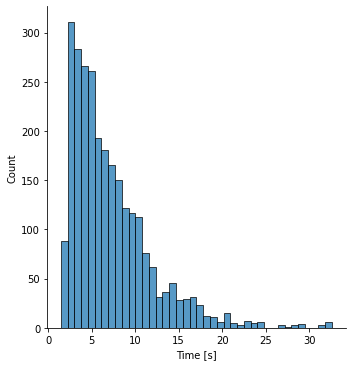

In [22]:
print('Audio lengths Distribution')
sns.displot(x=audio_lengths / sr)
plt.xlabel("Time [s]")

Ecco un esempio di audio scartato poiché danneggiato e non di buona qualità.

False


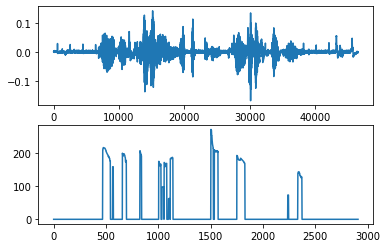

In [23]:
audio, _ = librosa.load(discarded_paths[0], sr)
print(is_voiced(audio, sr, min_voiced_sec=min_voiced_sec, plot=True))
ipd.Audio(audio, rate=sr)


# Process the dataset

Da quanto riportato nelle statistiche gli audio hanno delle lunghezze molto variabili, è quindi preferibile rimaneggiare il dataset dividendo quelli più lunghi in frammenti più brevi, tutti della stessa durata e facendo zero-padding sui più corti. 
Tagliare tutti gli audio ad una lunghezza standard avrebbe causato una grande perdita di materiale utile, che invece in questo modo viene conservato.

In [ ]:
fragment_dataset(processed_dataset_path, audio_paths, speaker_labels)

# Analyse the new dataset

Analizzo il nuovo dataset e scarto nuovamente gli audio che non contengono materiale voiced significativo. Ora questo check è essenziale, essendo probabile che segmentando audio lunghi si creino molti fremmenti silenziosi o con parti finali/iniziali di envelope (esempio riportato sotto).

In [ ]:
new_audio_paths, new_speaker_labels, new_gender_labels, new_audio_lengths, new_audio_channels, new_discarded_paths = \
    analyse_dataset(processed_dataset_path, metadata_path, min_legnth=min_length, min_voiced_seg=min_voiced_seg)

In [ ]:
print_statistics(new_audio_paths, new_speaker_labels, new_gender_labels, new_audio_lengths, 
                 new_audio_channels, new_discarded_paths)


GLOBAL STATISTICS

 - Tot. n. of audios: 10137
 - Tot. n. of speakers: 40
 - Tot. n. of discarded audios: 946
 - Max length: 2.0
 - Min length: 2.0
 - Avg length: 2.0
 - Median length: 2.0
 - Number of mono audios: 10137
 - Number of stereo audios: 0



GENDER STATISTICS

1) Gender: F
     - N. audios: 5104
     - Max length: 2.0
     - Min length: 2.0
     - Avg length: 2.0
     - Median length: 2.0
2) Gender: M
     - N. audios: 5033
     - Max length: 2.0
     - Min length: 2.0
     - Avg length: 2.0
     - Median length: 2.0


SPEAKER STATISTICS

1) Speaker id: 1272
     - N. audios: 253
     - Max length: 2.0
     - Min length: 2.0
     - Avg length: 2.0
     - Median length: 2.0
2) Speaker id: 1462
     - N. audios: 269
     - Max length: 2.0
     - Min length: 2.0
     - Avg length: 2.0
     - Median length: 2.0
3) Speaker id: 1673
     - N. audios: 245
     - Max length: 2.0
     - Min length: 2.0
     - Avg length: 2.0
     - Median length: 2.0
4) Speaker id: 174
     - N. aud

False


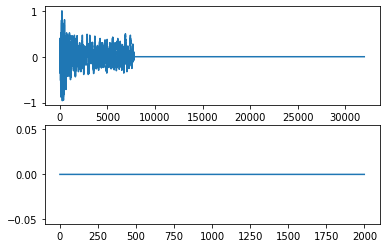

In [ ]:
audio, _ = librosa.load(new_discarded_paths[0], sr)
print(is_voiced(audio, sr, min_voiced_sec=min_voiced_sec, plot=True))
ipd.Audio(audio, rate=sr)

# Extract MFCCs and prepare dataset

Estraggo una matrice di MFCC da ogni audio e li salvo in un file JSON insieme a tutte le altre informazioni relative ai dati. Ho scelto di considerare 13 coefficienti, solitamente sufficienti per rappresentare il parlato.


In [ ]:
extract_MFCCs(new_audio_paths, new_speaker_labels, new_gender_labels, dataset_json_path, n_mfcc=n_mfcc)

# Outliers Detection

Carico il dataset appena salvato e analizzo la distribuzione degli MFCC. Per farlo considero singolarmente ogni coefficiente e per ogni audio calcolo alcune statistiche dei suoi valori lungo l'asse temporale. 
Dalla distribuzione della mediana in particolare è evidente la presenza di outliers (ho riportato i risultati più significativi, in particolare i primi coefficienti)

In [7]:
X, y, files, classes = load_dataset(dataset_json_path, task='gender_recognition') 

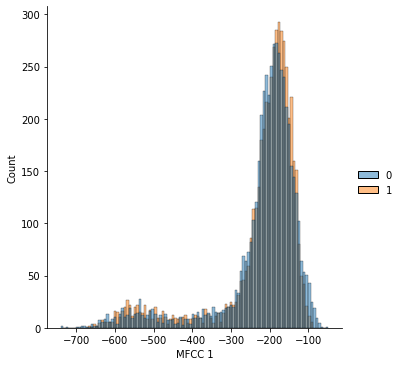

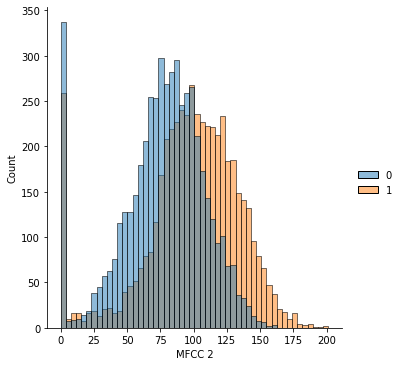

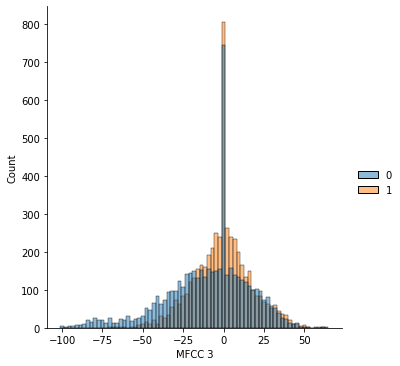

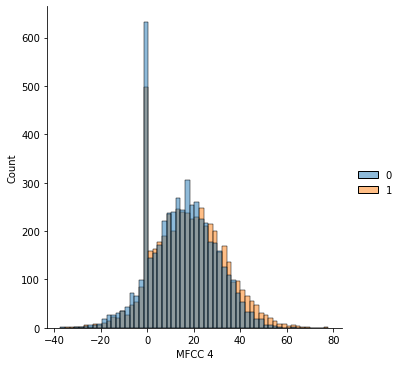

In [10]:
n_mfcc_inspect = 4

for coeff in range(n_mfcc_inspect):  
  coeff_median = []
  for i, sample in enumerate(X):
    coeffs = [t_bin[coeff] for t_bin in sample]
    coeff_median.append(statistics.median(coeffs))
  sns.displot(x=coeff_median, hue=y)
  plt.xlabel("MFCC {}".format(coeff + 1))


Come si può notare dal secodo coefficiente in poi è evidente la presenza di una grande quantità di audio in cui il valore più frequente per il coefficiente selezionato è 0. Questo accade verosimilmente per gli audio a cui è stato fatto zero-padding e che contengono prozioni importanti di silenzi. 
Per escludere gli outliers ho scelto come riferimento la distribuzione del secondo coefficiente, essendo il caso più estremo.
Ho escluso quindi quegli audio in cui ricorressero troppi zeri nella distribuzione temporale di questo coefficiente.
Per farlo ho selezionato una soglia massima di zeri (max_zeros). 

In [8]:
X, y, files = remove_outliers(X, y, files, ref_mel_coeff=2, max_zeros=10)

1378 outliers removed!


# Balance Dataset 

A questo punto è bene bilanciare il dataset per assicurarsi che entrambe le classi abbiano lo stesso numero di audio, atrimenti il modello potrebbe performare meglio per la classe più numerosa.

In [9]:
X, y, files = balance_dataset(X, y, files)

Each class contains 4360 audios


# Features Distribution

Analizzo nuovamente le distribuzioni statistiche dei singoli coefficienti per trovare qualche correlazione con le due classi. Ho riportato i casi più significativi in cui le due distribuzioni si discostano maggiormente, questo accade soprattutto per i coefficienti 4 e 12, che probabilmente codificano informazioni legate al genere. Inoltre, l'istogramma della mediana mostra come la cancellazione degli outliers abbia avuto effetto.

In [10]:
mean, std, median, min, max = feature_extraction(X)

MFCCs MEAN VALUE





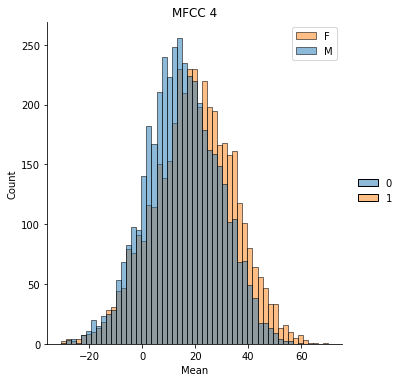

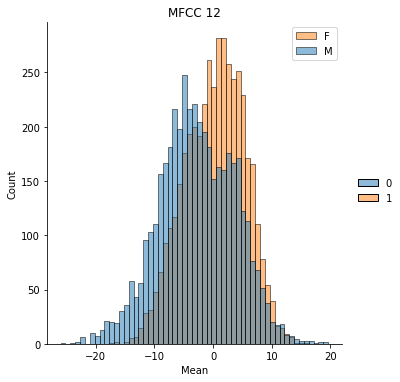

In [17]:
print("MFCCs MEAN VALUE")
print()
print()
print()
n_mfcc_selection = [4, 12]

for coeff in n_mfcc_selection:  
  sns.displot(x=mean[:, coeff - 1], hue=y)
  plt.title("MFCC {}".format(coeff))
  plt.xlabel("Mean")
  plt.legend(labels=classes)

MFCCs MEDIAN VALUE





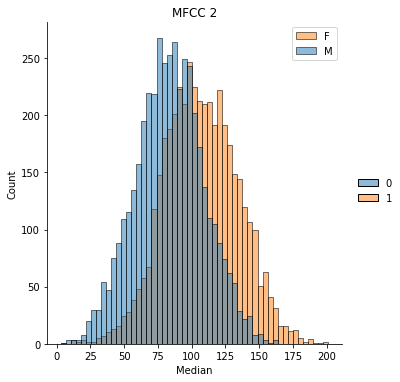

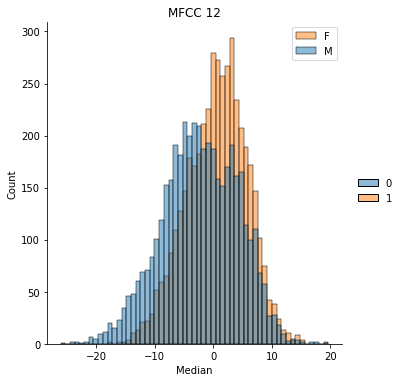

In [50]:
print("MFCCs MEDIAN VALUE")
print()
print()
print()
n_mfcc_selection = [2, 12]

for coeff in n_mfcc_selection:  
  sns.displot(x=median[:, coeff - 1], hue=y)
  plt.title("MFCC {}".format(coeff))
  plt.xlabel("Median")  
  plt.legend(labels=classes)

MFCCs MAX VALUE





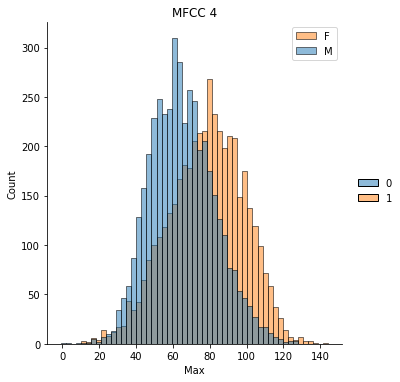

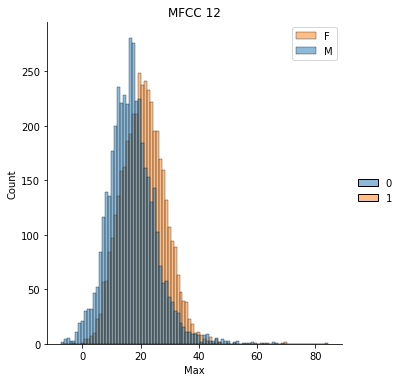

In [21]:
print("MFCCs MAX VALUE")
print()
print()
print()
n_mfcc_selection = [4, 12]

for coeff in n_mfcc_selection:  
  sns.displot(x=max[:, coeff - 1], hue=y)
  plt.title("MFCC {}".format(coeff))
  plt.xlabel("Max")
  plt.legend(labels=classes)

# Feature Normalization

Nell'ottica di ottenere per ogni audio un vettore di feature ho bisogno di passare da una rappresentazione bidimensionale (MFCCs) ad una monodimensionale. Per questo scelgo di riassumere con cinque statistiche (media, deviazione standard, mediana, minimo, massimo) i valori di ogni coefficiente lungo l'asse temporale, ottengo così un vettore lungo 65 (13 * 5). Successivamente normalizzo ogni feature (colonna del dataframe) sottraendo la sua media calcolata su tutti i sample e imponendo una varianza unitaria. Questo è necessario per far sì che le feature, aventi range diversi, siano portate tutte sulla stessa scala così da poter essere confrontate correttamente.

In [11]:
selected_features = ["mean", "std", "median", "min", "max"]
feature_names = []
for feat in selected_features:
  feature_names.extend([feat + str(i + 1) for i in range(n_mfcc)])

features = []

for i, _ in enumerate(X):
  feature_vector = np.concatenate((mean[i,:], std[i,:], median[i,:], min[i,:], max[i,:]), axis=None)
  features.append(feature_vector)

features = pd.DataFrame(features, columns=feature_names)
features.head()

,mean1,mean2,mean3,mean4,mean5,mean6,mean7,mean8,mean9,mean10,mean11,mean12,mean13,std1,std2,std3,std4,std5,std6,std7,std8,std9,std10,std11,std12,std13,median1,median2,median3,median4,median5,median6,median7,median8,median9,median10,median11,median12,median13,min1,min2,min3,min4,min5,min6,min7,min8,min9,min10,min11,min12,min13,max1,max2,max3,max4,max5,max6,max7,max8,max9,max10,max11,max12,max13
0,-218.411732,26.792871,36.102605,2.640070,4.944906,-8.473085,-11.223858,1.447939,3.579721,5.129018,-0.988964,0.515822,-1.827044,140.687348,50.897637,43.274897,34.557626,17.360689,18.477519,13.666687,13.277625,13.324093,10.044229,10.465437,9.422014,8.211765,-169.872772,20.779047,37.143192,-1.334069,0.523639,-4.057413,-11.468495,2.549033,6.765078,3.335072,-0.092487,-0.363463,-1.720204,-517.648621,-99.039589,-36.066521,-53.261253,-20.439011,-55.376743,-38.040688,-31.522770,-34.809284,-14.934088,-25.658012,-21.212269,-23.904217,-2.254899,101.211113,165.416306,64.175583,56.034233,19.693634,18.761440,29.895119,22.281509,26.332155,19.345968,19.535387,15.696563
1,-172.938297,32.984635,45.310204,8.283856,17.380323,-12.275452,-8.707889,-1.516951,-3.335268,-1.188642,0.359463,0.775470,-1.870813,68.053887,80.385188,45.191687,29.651143,14.916770,19.747317,20.015009,16.299645,15.912209,12.370396,8.574705,9.154286,9.318561,-168.564819,37.252598,50.368073,4.371205,15.795216,-12.237529,-6.240558,2.984970,-0.868187,-3.007841,0.438579,0.050435,0.255277,-390.848602,-154.010147,-41.686012,-48.419800,-6.206091,-59.621193,-65.826843,-37.872089,-36.508640,-23.582573,-22.620218,-16.297499,-29.690750,-26.463100,163.143219,116.118187,69.535507,61.681675,26.544140,32.836269,27.134914,23.914019,34.122078,16.478840,23.351686,13.224606
2,-190.570646,65.691442,27.566529,5.860818,11.232189,-11.070159,-6.879910,-4.383322,1.115685,-0.148235,2.447687,-0.266479,5.901963,111.450218,73.005374,37.734213,30.661232,15.184717,19.301934,15.007741,14.191680,13.829411,9.979733,8.630762,7.846471,9.368232,-144.804520,59.974457,29.817669,9.999265,12.608217,-8.650501,-6.125198,-4.619787,4.590308,-0.800193,1.000782,-1.986961,4.962489,-470.070709,-98.759445,-54.204483,-75.362823,-16.331324,-46.478271,-41.516953,-34.955833,-35.821526,-24.440773,-13.340748,-14.427370,-12.524466,-15.095908,214.469238,101.590393,61.279816,45.032158,35.271729,22.743332,26.608437,24.800446,21.691689,27.677750,17.253094,25.160660
3,-243.357966,54.227768,20.234669,-4.406631,8.519693,-0.070903,-6.210276,1.070224,3.270662,3.647182,1.215691,1.208315,0.669889,152.318342,80.435599,28.653788,26.262469,12.550876,13.411442,13.912339,17.266333,13.035578,11.357565,7.782757,6.970653,9.673936,-173.576553,50.537941,23.497913,0.019028,9.759993,3.849558,-4.579366,6.091134,6.209550,5.492092,2.555267,0.534128,3.606713,-516.201904,-109.160690,-31.965412,-65.386276,-34.368382,-40.145981,-43.157352,-43.498871,-27.226387,-35.631371,-20.828716,-15.591213,-25.837200,-24.170280,185.095688,101.664322,39.455391,31.568550,21.086601,15.068859,25.290127,21.593754,26.655409,15.731833,19.973944,20.111534
4,-140.897201,78.938187,40.346365,8.434367,-2.317425,-18.550044,-1.811607,-5.292744,-10.156833,4.396059,3.894000,-1.392413,-2.895487,60.024818,58.127385,31.058525,31.140709,23.463205,15.782907,13.500068,13.915803,16.585529,10.165437,8.882424,9.265630,8.639256,-134.731323,77.071976,40.346725,17.131649,1.098180,-16.935455,-0.393000,-5.095712,-4.495070,5.323954,5.602420,-0.669352,-3.062388,-304.852966,-94.279709,-14.335815,-59.769066,-59.573235,-48.380909,-37.295929,-36.271370,-45.172836,-19.938059,-21.107941,-21.386003,-19.248264,-44.180798,163.155624,105.628960,57.849930,38.021713,21.178070,26.321575,26.056557,21.237804,26.259287,16.836983,21.968830,13.523863


In [12]:
standard_scaler = preprocessing.StandardScaler()
scaled_features = standard_scaler.fit_transform(features)
features = pd.DataFrame(scaled_features, columns=feature_names)
features.head()

,mean1,mean2,mean3,mean4,mean5,mean6,mean7,mean8,mean9,mean10,mean11,mean12,mean13,std1,std2,std3,std4,std5,std6,std7,std8,std9,std10,std11,std12,std13,median1,median2,median3,median4,median5,median6,median7,median8,median9,median10,median11,median12,median13,min1,min2,min3,min4,min5,min6,min7,min8,min9,min10,min11,min12,min13,max1,max2,max3,max4,max5,max6,max7,max8,max9,max10,max11,max12,max13
0,-0.089038,-2.342948,1.860971,-1.007979,1.266947,-0.053762,0.050035,0.472676,0.715714,1.499871,0.127057,0.290790,0.566306,0.884913,-0.116427,0.556254,1.536223,-1.035338,0.054625,-0.606311,-0.446019,0.394012,-0.500585,0.177039,-0.118502,-0.493258,0.398017,-2.596106,1.801961,-1.316579,0.874570,0.214578,-0.044525,0.473685,1.060845,1.097293,0.211106,0.077546,0.532316,-0.858644,-1.268944,1.578864,-0.696992,1.975470,-0.599062,0.633868,0.348382,-0.488193,1.570530,-0.126941,0.244710,0.226768,1.384213,-2.466047,3.451375,-0.368137,1.827889,-0.637388,-0.006460,0.377791,-0.183017,0.869152,-0.059029,0.060104,0.126482
1,0.819405,-2.107429,2.254097,-0.619539,2.044727,-0.348520,0.292060,0.159150,-0.183958,0.491370,0.322487,0.334006,0.558942,-1.111949,2.154934,0.785511,0.621156,-1.487379,0.433348,1.378751,0.476834,1.397063,0.540790,-0.761077,-0.253471,0.038372,0.424217,-2.020887,2.357308,-0.924288,1.779378,-0.386537,0.432758,0.517922,0.083877,0.117308,0.287536,0.146226,0.860368,0.585748,-2.536486,1.408367,-0.460306,2.595503,-0.879319,-1.285497,-0.114708,-0.644234,0.647889,0.197869,0.821443,-0.427553,0.625424,-0.493312,1.656871,-0.099522,2.187862,-0.182394,1.239840,0.112227,-0.020126,1.812689,-0.373697,0.526740,-0.170356
2,0.467156,-0.863349,1.496516,-0.786307,1.660189,-0.255086,0.467904,-0.143957,0.395132,0.657453,0.625137,0.160583,1.866712,0.081117,1.586483,-0.106438,0.809539,-1.437818,0.300510,-0.186976,-0.166888,0.589853,-0.529458,-0.733264,-0.912776,0.062231,0.900169,-1.227492,1.494343,-0.537306,1.590555,-0.122945,0.443289,-0.253771,0.782500,0.458391,0.368447,-0.191849,1.642057,-0.316679,-1.262484,1.028555,-1.777482,2.154414,-0.011506,0.393740,0.097990,-0.581141,0.556334,1.190058,1.040898,1.513552,0.981721,1.141586,1.128044,-0.513260,1.126606,0.397271,0.346129,0.061574,0.068321,0.307086,0.855386,-0.218963,1.262954
3,-0.587400,-1.299397,1.183477,-1.492977,1.490534,0.597573,0.532320,0.432734,0.675504,1.263322,0.446581,0.406050,0.986415,1.204676,2.158817,-1.192499,-0.010838,-1.924988,-1.456357,-0.529498,0.772038,0.282195,0.087368,-1.154015,-1.354300,0.209070,0.323825,-1.556994,1.228961,-1.223541,1.421804,0.795621,0.584415,0.833120,0.989744,1.430554,0.592165,0.226487,1.416915,-0.842164,-1.502322,1.703292,-1.289754,1.368660,0.406607,0.280427,-0.525099,0.208095,-0.637507,0.389422,0.904324,0.008193,0.697291,0.205945,1.130735,-1.607001,0.268423,-0.544871,-0.333431,-0.065262,-0.251641,0.908306,-0.455681,0.113728,0.656643
4,1.459504,-0.359478,2.042162,-0.609180,0.812721,-0.834924,0.955454,-0.240125,-1.071475,1.382867,0.834754,-0.026820,0.386541,-1.332686,0.440465,-0.904881,0.898963,0.093419,-0.749056,-0.658411,-0.251134,1.658015,-0.446323,-0.608398,-0.197339,-0.287920,1.101949,-0.630486,1.936486,-0.046887,0.908610,-0.731764,0.966608,-0.302065,-0.380321,1.404576,1.030705,0.026788,0.309430,1.565332,-1.159188,2.238177,-1.015143,0.270654,-0.137135,0.685313,0.002041,-1.439811,1.036694,0.359566,0.224322,0.753248,0.070076,-0.492917,1.275052,-0.685150,0.679754,-0.538796,0.662976,0.008477,-0.287157,0.860326,-0.334390,0.357652,-0.134421


# Dataset Partition

Divido il dataset in train e test destinando il 10% dei dati a quest'ultimo.

In [69]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.1)

print('Training Samples: {}'.format(len(X_train)))
print('Test Samples: {}'.format(len(X_test)))

Training Samples: 7848
Test Samples: 872


# Classifiers


# Random Forest (First Baseline)

Come prima baseline ho scelto un classificatore semplice, un Random Forest con 100 alberi (valore di default) e una max_depth di 1.
Le performance sono valutate attraverso accuracy, precision, recall, ROC e AUC.
I risultati sono già buoni, quindi probabilmente le feature usate per rappresentare i dati permettono di discriminare bene le due classi.

Accuracy = 0.7856
Precision = 0.8000
Recall = 0.7575



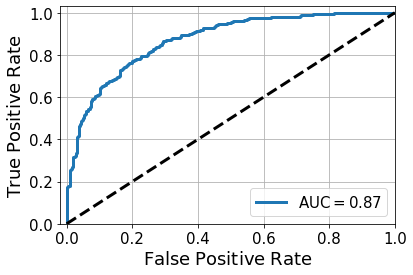

In [74]:
clf = RandomForestClassifier(max_depth=1, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
metrics(y_test, y_pred[:, 1])

## Support Vector Machine (Second Baseline)
Come classificatore più sofisticato ho scelto un SVM. Le performance migliorano sensibilmente, fino a raggiungere quasi una classificazione perfetta. Non a caso l'SVM si conferma come uno dei metodi di machine learning più usati, capace di eccellere in task di difficoltà ridotta, dove non è necessario ricorrere al deeplearning.

Accuracy = 0.9908
Precision = 0.9908
Recall = 0.9908



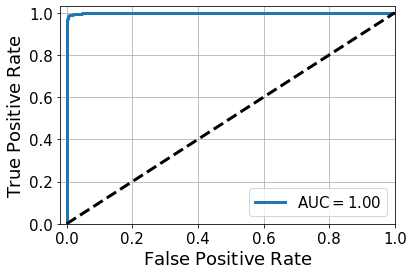

In [42]:
clf = SVC(gamma='auto', probability=True)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
metrics(y_test, y_pred[:, 1])

# Multilayer Perceptron (linear activations)
Come prima rete neurale ho scelto il Multilayer Perceptron con funzioni di attivazione esclusivamente lineari per vedere se i dati fossero linearmente separabili. La potenza del deepleaning infatti si basa sull'utilizzo di funzioni non lineari successive che permettono al modello di imparare distribuzioni non lineari dei dati molto complesse. Come si può vedere dalle performance il MLP raggiunge comunque buoni risultati, migliori della baseline naive, quindi probabilmente la distribuzione dei dati nel feature space non presenta grosse non linearità. La rete presenta un input layer, due hidden layers alternati da dropout e batch normalization e un output layer. Per fase di training ho estratto dal training set una porzione del 10% come validation set su cui monitorare l'allenamento epoca per epoca e i dati vengono passati in batch size di 32 (default di Keras). Inoltre, mediante l'uso dell'early stopping faccio terminare il training automaticamente se la validation loss non diminuisce dopo un certo numero di epoche (patience).
Come si può vedere dai plot delle validation/training loss e accuracy il modello non overfitta, complici i layer di batch normalization e dropout. Tuttavia per il validation set i risultati sembrano essere molto migliori: questo può essere dovuto proprio al dropout che durante il training disattiva alcuni nodi della rete, mentre durante il calcolo delle metriche sul validation set non è attivo e la rete risulta più performante. Trattandosi di classificazione binaria l'ultima funzione di attivazione è sigmoidale e la loss function è la binary crossentropy. Come ottimizzatore ho scelto adam essendo uno standard che funziona bene. 

In [58]:
X_train = tf.convert_to_tensor(X_train, dtype="float32")
y_train = tf.convert_to_tensor(y_train, dtype="int64")

In [83]:
input_shape = len(X_train[0])

input_ = Input(shape=input_shape, name="input")
x = Dense(input_shape, activation="linear", name="first_FC")(input_)
x = BatchNormalization(name="first_BN")(x)
x = Dropout(0.4, name="first_dropout")(x)
x = Dense(13, activation="linear", name="second_FC")(x)
x = BatchNormalization(name="second_BN")(x)
x = Dropout(0.4, name="second_dropout")(x)
x = Dense(1, activation="sigmoid", name="output")(x)

model = Model(input_, x, name="multilayer_perceptron")

model.summary()


Model: "multilayer_perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 65)]              0         
                                                                 
 first_FC (Dense)            (None, 65)                4290      
                                                                 
 first_BN (BatchNormalizatio  (None, 65)               260       
 n)                                                              
                                                                 
 first_dropout (Dropout)     (None, 65)                0         
                                                                 
 second_FC (Dense)           (None, 13)                858       
                                                                 
 second_BN (BatchNormalizati  (None, 13)               52        
 on)                                         

In [84]:
# TRAINING
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)
mc = ModelCheckpoint(os.path.join(trained_models_path, 'MLP_best_model.h5'), 
                     monitor='val_loss', mode='min', save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mlp_history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, callbacks=[es, mc])

Epoch 1/100
221/221 [==============================] - 4s 11ms/step - loss: 0.4578 - accuracy: 0.7824 - val_loss: 0.2782 - val_accuracy: 0.8752
Epoch 2/100
221/221 [==============================] - 1s 4ms/step - loss: 0.3453 - accuracy: 0.8502 - val_loss: 0.2668 - val_accuracy: 0.8713
Epoch 3/100
221/221 [==============================] - 1s 4ms/step - loss: 0.3265 - accuracy: 0.8655 - val_loss: 0.2630 - val_accuracy: 0.8752
Epoch 4/100
221/221 [==============================] - 1s 4ms/step - loss: 0.3175 - accuracy: 0.8611 - val_loss: 0.2607 - val_accuracy: 0.8790
Epoch 5/100
221/221 [==============================] - 1s 4ms/step - loss: 0.3254 - accuracy: 0.8587 - val_loss: 0.2623 - val_accuracy: 0.8790
Epoch 6/100
221/221 [==============================] - 1s 4ms/step - loss: 0.3083 - accuracy: 0.8716 - val_loss: 0.2587 - val_accuracy: 0.8803
Epoch 7/100
221/221 [==============================] - 1s 3ms/step - loss: 0.3060 - accuracy: 0.8697 - val_loss: 0.2571 - val_accuracy: 0.882

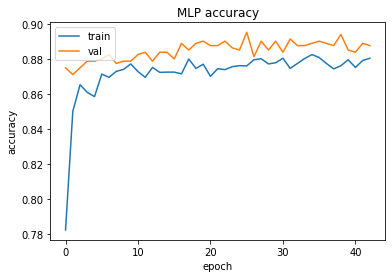

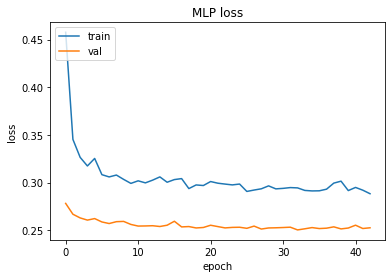

In [85]:
plt.plot(mlp_history.history['accuracy'])
plt.plot(mlp_history.history['val_accuracy'])
plt.title('MLP accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(mlp_history.history['loss'])
plt.plot(mlp_history.history['val_loss'])
plt.title('MLP loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Accuracy = 0.8945
Precision = 0.9007
Recall = 0.8926



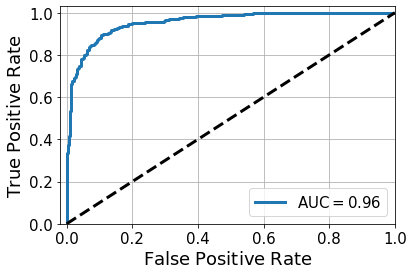

In [86]:
mlp_model = load_model(os.path.join(trained_models_path, 'MLP_best_model.h5'))
y_pred = mlp_model.predict(X_test)
metrics(y_test, y_pred)

## 2D Convolutional Neural Network
Come seconda rete neurale ho scelto una Convolutional Neural Network. Tale rete si presta particolarmente alla struttura bidimensionale degli MFCC estratti, li ho quindi dati come input diretti senza considerare le loro statistiche come per i modelli precedenti. In questo modo sarà la rete ad estrarre dagli MFCC le rappresentazioni più informative, senza passare per il "filtro umano". Questa volta ho usato funzioni di attivazione non lineari, LeakyRelu nello specifico, che limitano i problemi di vanishing gradients e accelerano l'allenamento. L'architettura della rete si compone di un input layer, tre strati convoluionali alternati da Maxpooling, batch normalization e dropout e due strati fully connected, dopo il flattening. La loss function, l'ultima funzione di attivazione, la batch size e l'ottimizzatore sono gli stessi della rete precedente. Anche in questo caso i grafici mostrano che la rete non overfitta, complici sempre gli strati di batch normalization e dropout. Le performance di questo modello sono molto simili a quelle della baseline SVM, anche se leggermente migliori. Questo suggerisce quanto in un problema di questo tipo sia perfettamente ragionevole usare un algoritmo standard di machine learning piuttosto che uno di DeepLearning che solitamente richiede più risorse.

In [16]:
X_train_2D, X_test_2D, y_train_2D, y_test_2D = train_test_split(X, y, test_size=0.1)
X_train_2D = tf.convert_to_tensor(X_train_2D, dtype="float32")
y_train_2D = tf.convert_to_tensor(y_train_2D, dtype="int64")

In [65]:
input_shape = (X_train_2D.shape[1], X_train_2D.shape[2], 1)

input_ = Input(shape=input_shape, name="input")
x = Conv2D(32, (3,3), activation="leaky_relu", name="first_conv2D")(input_)
x = BatchNormalization(name="first_BN")(x)
x = Conv2D(64, (3,3), activation="leaky_relu", name="second_conv2D")(x)
x = BatchNormalization(name="second_BN")(x)
x = MaxPool2D(name="first_maxpool", padding='same')(x)
x = Dropout(0.4, name="first_dropout")(x)
x = Conv2D(128, (3,3), activation="leaky_relu", name="third_conv2D")(x)
x = BatchNormalization(name="third_BN")(x)
x = MaxPool2D(name="second_maxpool", padding='same')(x)
x = Dropout(0.4, name="second_dropout")(x)
x = Flatten(name="flatten")(x)
x = Dense(1024, activation="leaky_relu", name="first_FC")(x)
x = Dropout(0.4, name="third_dropout")(x)
x = Dense(256, activation="leaky_relu", name="second_FC")(x)
x = Dropout(0.2, name="fourth_dropout")(x)
x = Dense(1, activation="sigmoid", name="output")(x)

model = Model(input_, x, name="convolutional_2D")

model.summary()


Model: "convolutional_2D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 63, 13, 1)]       0         
                                                                 
 first_conv2D (Conv2D)       (None, 61, 11, 32)        320       
                                                                 
 first_BN (BatchNormalizatio  (None, 61, 11, 32)       128       
 n)                                                              
                                                                 
 second_conv2D (Conv2D)      (None, 59, 9, 64)         18496     
                                                                 
 second_BN (BatchNormalizati  (None, 59, 9, 64)        256       
 on)                                                             
                                                                 
 first_maxpool (MaxPooling2D  (None, 30, 5, 64)   

In [66]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=9)
mc = ModelCheckpoint(os.path.join(trained_models_path, 'CNN_best_model.h5'), 
                     monitor='val_loss', mode='min', save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_history = model.fit(X_train_2D, y_train_2D, validation_split=0.1, epochs=100, callbacks=[es, mc])

Epoch 1/100
221/221 [==============================] - 3s 8ms/step - loss: 0.6634 - accuracy: 0.7791 - val_loss: 0.1866 - val_accuracy: 0.9274
Epoch 2/100
221/221 [==============================] - 1s 6ms/step - loss: 0.2703 - accuracy: 0.9019 - val_loss: 0.3167 - val_accuracy: 0.9045
Epoch 3/100
221/221 [==============================] - 2s 7ms/step - loss: 0.1706 - accuracy: 0.9364 - val_loss: 0.0779 - val_accuracy: 0.9656
Epoch 4/100
221/221 [==============================] - 1s 6ms/step - loss: 0.1369 - accuracy: 0.9492 - val_loss: 0.2707 - val_accuracy: 0.8981
Epoch 5/100
221/221 [==============================] - 1s 7ms/step - loss: 0.1039 - accuracy: 0.9632 - val_loss: 0.1694 - val_accuracy: 0.9350
Epoch 6/100
221/221 [==============================] - 2s 7ms/step - loss: 0.0955 - accuracy: 0.9669 - val_loss: 0.0452 - val_accuracy: 0.9834
Epoch 7/100
221/221 [==============================] - 1s 6ms/step - loss: 0.0919 - accuracy: 0.9683 - val_loss: 0.0497 - val_accuracy: 0.9822

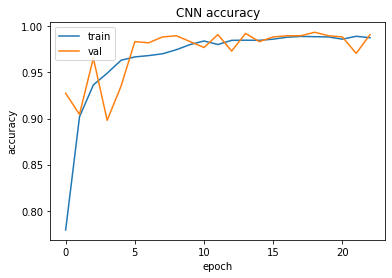

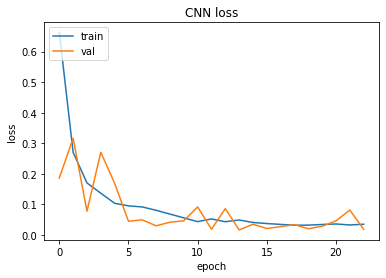

In [67]:
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('CNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('CNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Accuracy = 0.9931
Precision = 0.9913
Recall = 0.9956



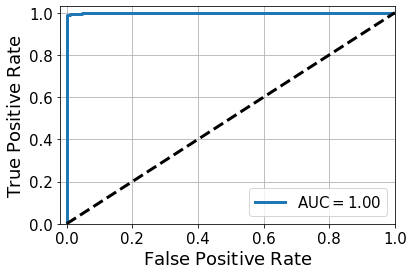

In [68]:
cnn_model = load_model(os.path.join(trained_models_path, 'CNN_best_model.h5'))
y_pred = cnn_model.predict(X_test_2D)
metrics(y_test_2D, y_pred)